<a href="https://colab.research.google.com/github/realgjl/nature_gas/blob/main/Nat_Gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, download the data in a CSV file.

Use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

1. Download the monthly natural gas price data.
2. Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
3. Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future.
4. The code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

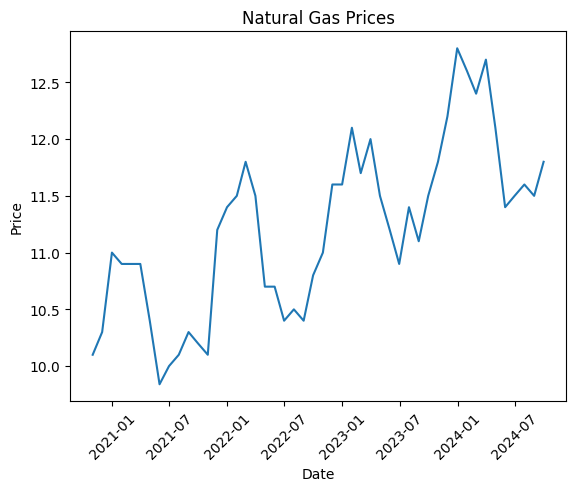

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/realgjl/nature_gas/main/Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# Plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)
plt.show()

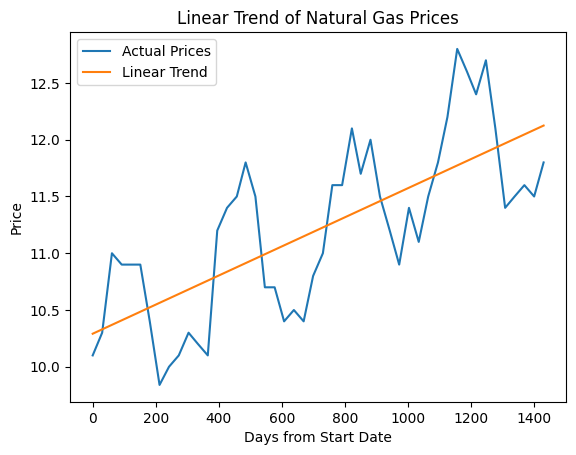

Slope: 0.001282373598760221 Intercept: 10.29104112595228


In [2]:
# Calculate days from start for regression
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_from_start = [(day - start_date).days for day in months]

# Simple linear regression
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar)**2)
    intercept = ybar - slope * xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices, label='Actual Prices')
plt.plot(time, time * slope + intercept, label='Linear Trend')
plt.xlabel('Days from Start Date')
plt.ylabel('Price')
plt.title('Linear Trend of Natural Gas Prices')
plt.legend()
plt.show()
print("Slope:", slope, "Intercept:", intercept)

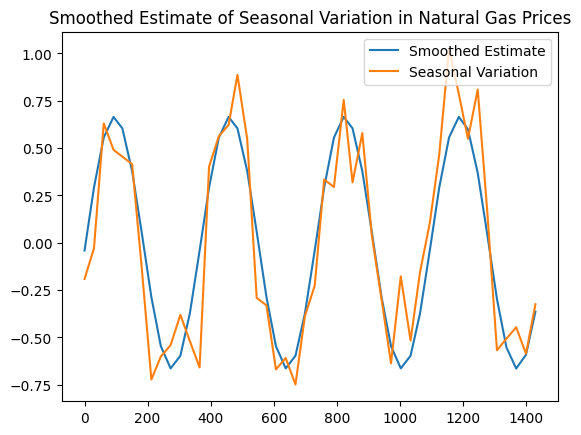

In [3]:
# Subtract linear trend from prices to isolate seasonal variation
sin_prices = prices - (time * slope + intercept)

# Fit a sine curve to the seasonal variation
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift), label='Smoothed Estimate')
plt.plot(time, sin_prices, label='Seasonal Variation')
plt.title('Smoothed Estimate of Seasonal Variation in Natural Gas Prices')
plt.legend()
plt.show()

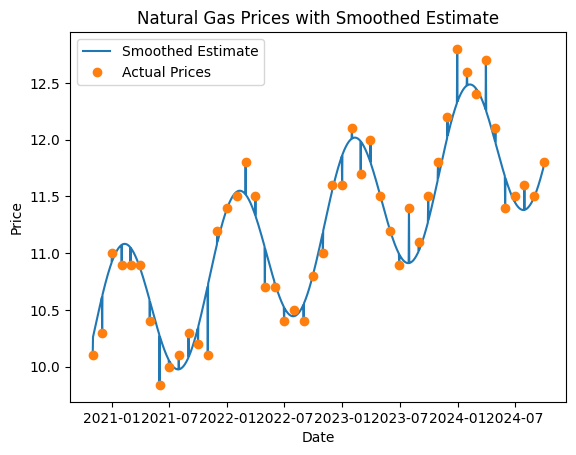

In [4]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        return prices[days_from_start.index(days)]
    else:
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')
plt.plot(dates, prices, 'o', label='Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices with Smoothed Estimate')
plt.legend()
plt.show()